In [9]:
0.1+0.1+0.1

0.30000000000000004

# CA5 - Eirik Høyheim

## Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.cross_decomposition import PLSRegression 
from xgboost import XGBRegressor

## Preprocess data, remove missing values and edit "demo_25"

In [2]:
train_raw = pd.read_pickle("train4.pkl")  # read in data
sub = pd.read_pickle("test4.pkl")
train_raw.head()

,demo_0,demo_1,demo_2,demo_3,demo_4,demo_5,demo_6,demo_7,demo_8,demo_9,...,demo_115,demo_116,demo_117,demo_118,demo_119,demo_120,demo_121,demo_122,demo_123,target
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,...,6.5,1845.9,9.63,missing,missing,missing,missing,0.0,missing,8.20
1,20009,3.22,1.64,92.31,3.18,7.15,13.17,28.71,10.22,2.18,...,4.2,4728.0,0.00,missing,missing,missing,missing,0.0,missing,71.99
2,66049,2.63,26.41,72.45,0.76,0.72,17.79,29.84,18.19,14.33,...,51.2,1290.5,3.33,62,5585480,89.13,0,5.8,83166.8,159.32
3,11157,2.39,0.29,98.87,0.62,0.61,10.72,22.81,11.00,17.50,...,3.0,3726.5,0.90,missing,missing,missing,missing,0.0,missing,24.66
4,17192,2.69,0.58,97.40,1.07,0.76,14.30,30.82,14.81,9.56,...,6.8,2510.4,2.26,missing,missing,missing,missing,0.0,missing,35.62


In [3]:
type(train_raw["demo_25"][0])

str

Both train and sub contains missing values in some of the columns and `demo_25` contains string values, so need to transform these two.

In [4]:
train_with_nan = copy.copy(train_raw.replace("missing", np.nan))  # replace nan values with nan
train_only_25_nan = copy.copy(train_with_nan[(train_with_nan.isnull().sum()[train_with_nan.isnull().sum() <= 1]).index])  # remove all columns that contain more than 1 nan value
train_only_25_nan["demo_25"] = [float(x) for x in train_only_25_nan["demo_25"]]  # transforming all values from string to float
median_demo25 = train_only_25_nan["demo_25"].median()
train_no_nan = copy.copy(train_only_25_nan.fillna(median_demo25))  # replaces the nan value with median

# same procedure with submission data
sub_with_nan = copy.copy(sub.replace("missing", np.nan))  
sub_only_25_nan = copy.copy(sub_with_nan[(sub_with_nan.isnull().sum()[sub_with_nan.isnull().sum() <= 1]).index])
sub_only_25_nan["demo_25"] = [float(x) for x in sub_only_25_nan["demo_25"]] 
sub_no_nan = copy.copy(sub_only_25_nan.fillna(median_demo25))  # replaces the nan value with median of train demo_25
train_no_nan.shape, sub_no_nan.shape

((1089, 103), (1089, 102))

In [5]:
train = copy.copy(train_no_nan)

X = train.iloc[:, :-1]
y = train.iloc[:, -1]  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1234)

## Exploration of the data

##### Note: used fewer features on some of the plots to make the it faster to read through

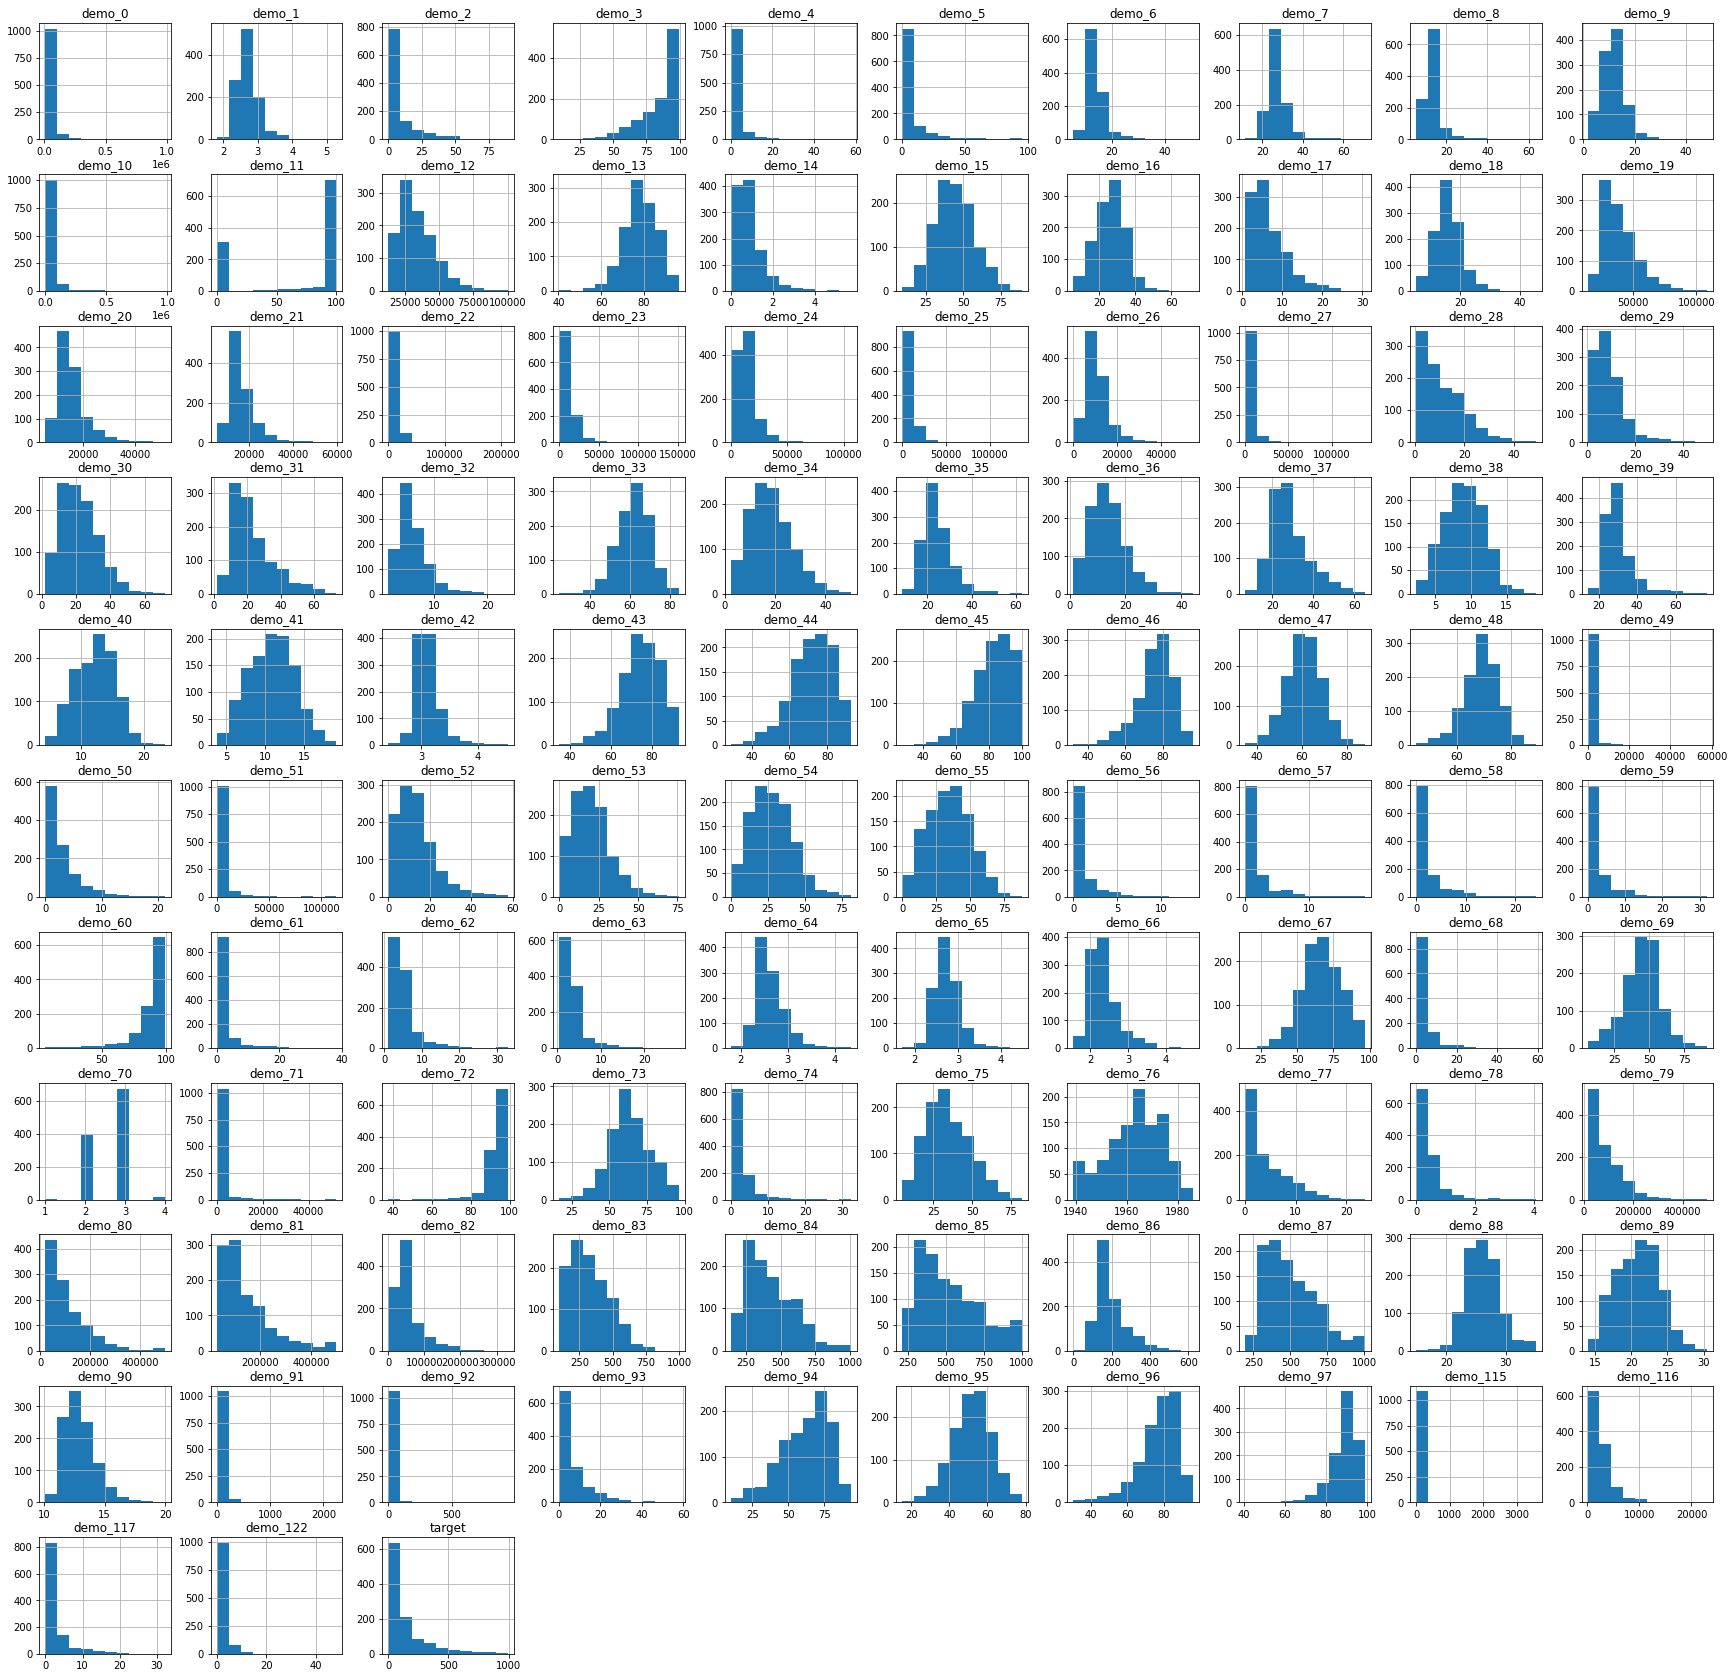

In [6]:
train.hist(figsize=(30,30))  # see histograms of all features too see how they are distributed
plt.show()

`target` is very left skewed, and a lot of the other features are skewed too. It will probably not effect prediction when using Randomforest or XGBoost, but the ones that are skewed may be more correlated to `target` than those that are not skewed.

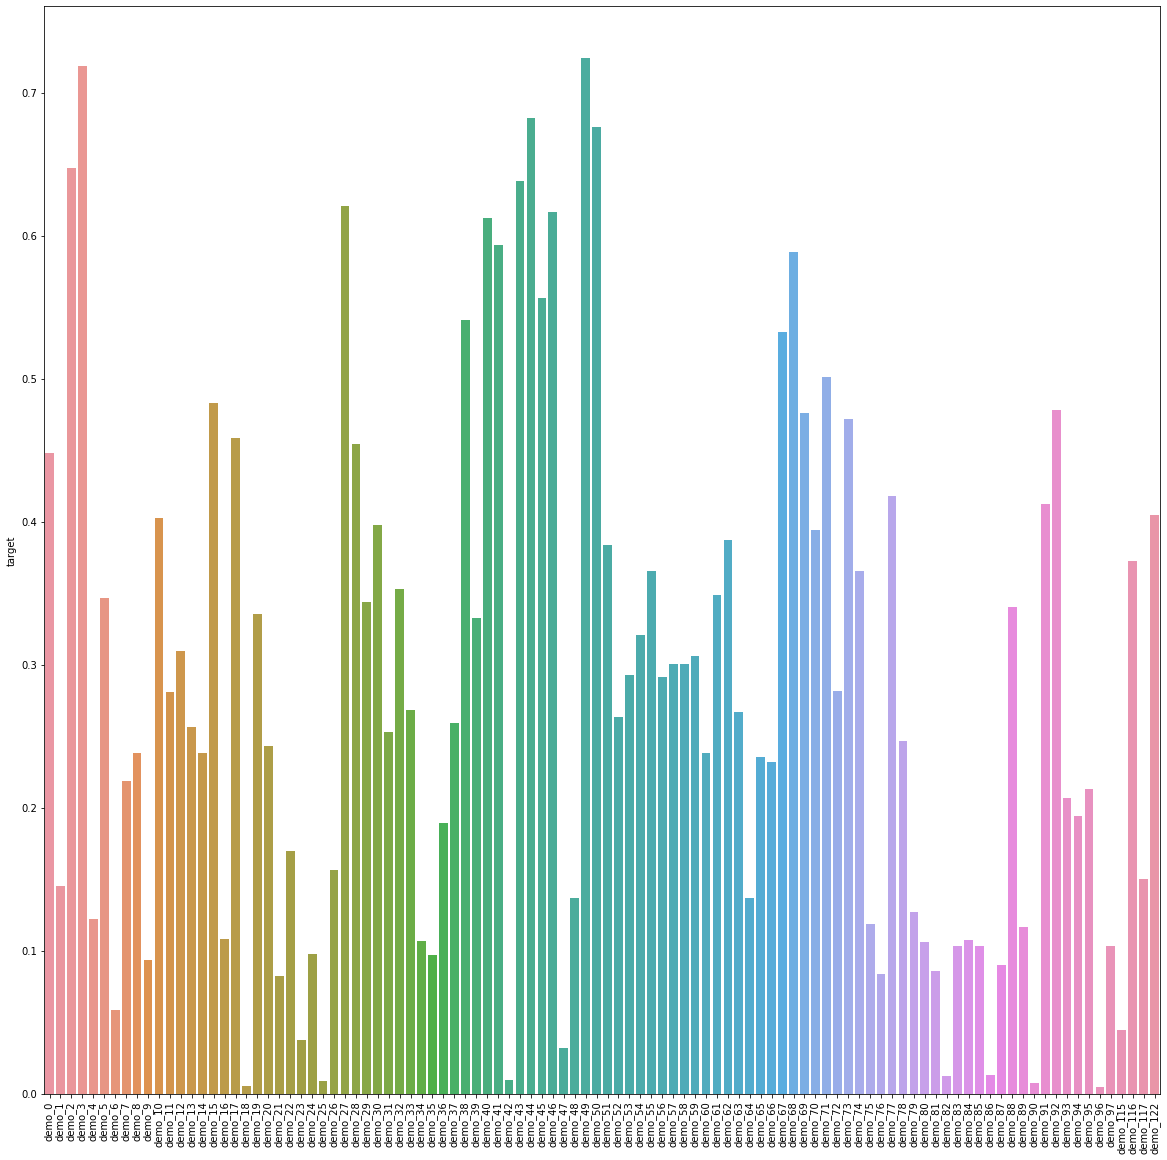

In [7]:
corr = train.corr(method="spearman")  # used spearman method to see if there were any non linear correlation too
fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(x=corr["target"].index[:-1], y=abs(corr["target"][:-1]))
plt.xticks(rotation=90)
plt.show()

Some of the features are highly correlated to target. These features will typically help more when predicting.

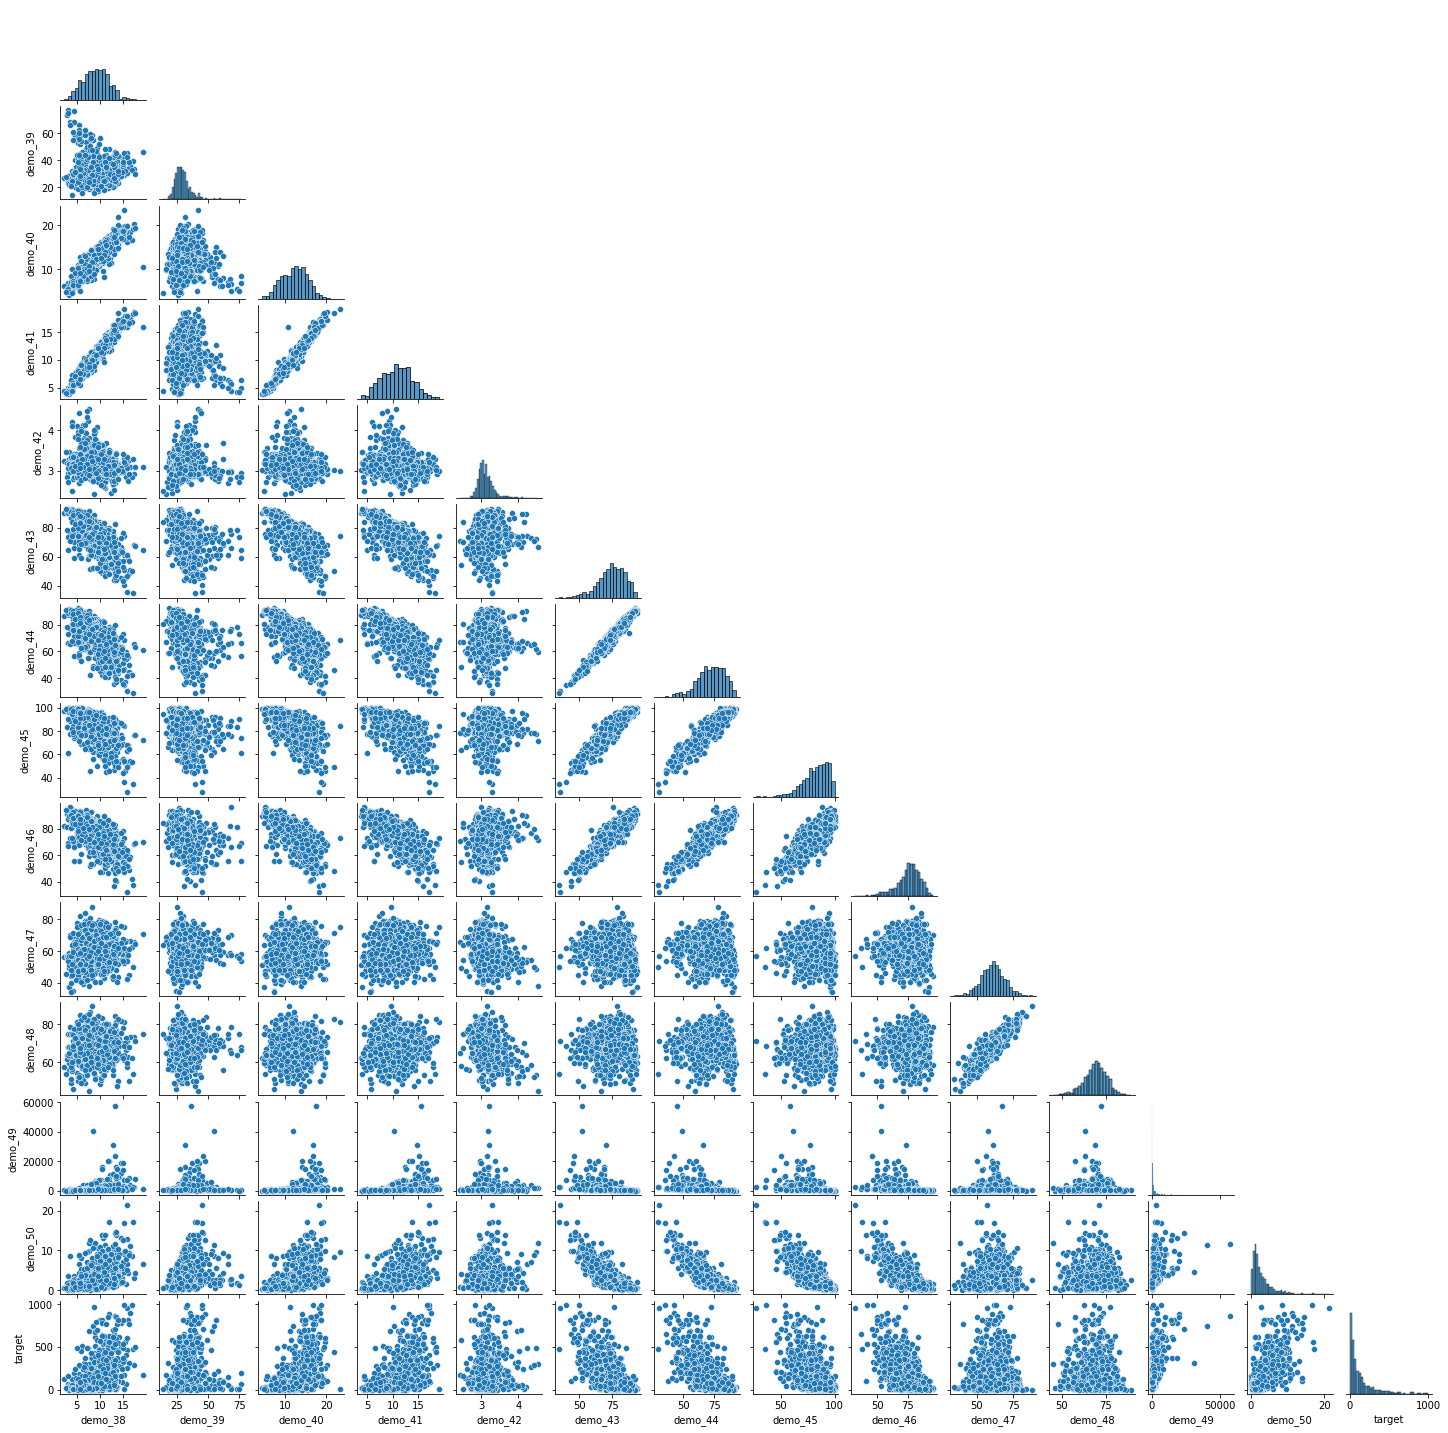

In [8]:
g = sns.pairplot(train.iloc[:, [38,39,40,41,42,43,44,45,46,47,48,49,50,-1]], corner=True)  # splitting up data for easier visualization
g.fig.set_figheight(20)
g.fig.set_figwidth(20)
plt.show()

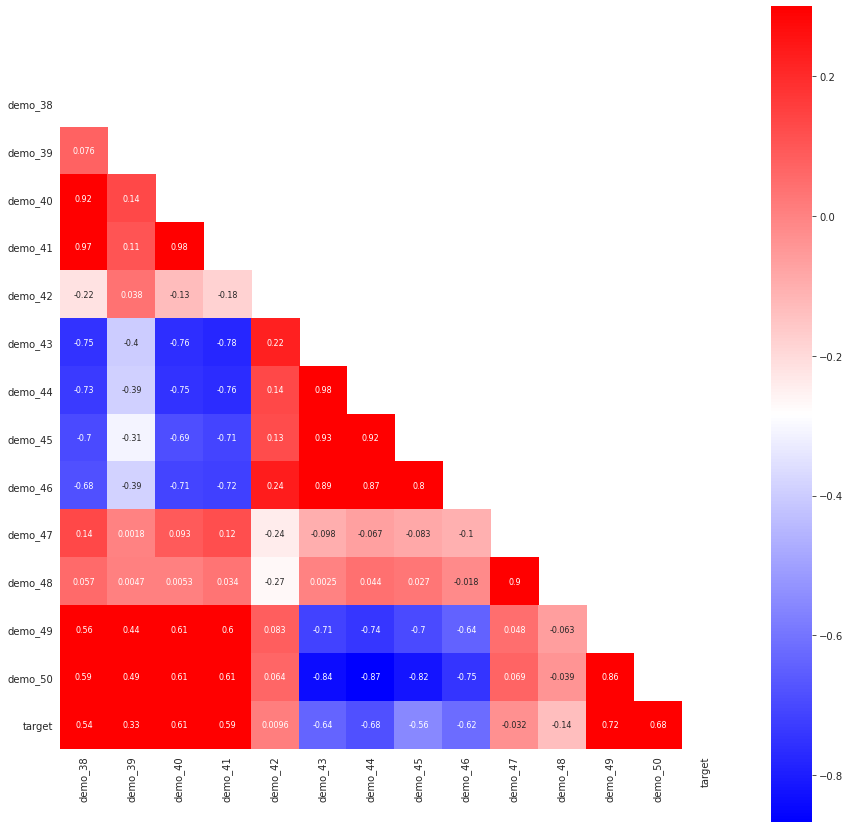

In [9]:
corr = (train.iloc[:, [38,39,40,41,42,43,44,45,46,47,48,49,50,-1]].corr(method="spearman"))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, ax=ax, cmap="bwr", annot_kws={"fontsize":8})

plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

We want to look after features that have some type of relationship with target in the pairplot and, in the correlation matrix, we want to see which featrues that has the highest correlation too target. 

In the correlation matrix, we can see that some of the features is highly correlated to each other, like demo_43 to demo_44 and demo_41 to demo_40. In the pairplot, we can see that these features also have a linear relationship with each other, which is because they are dependent on each other and/or they are the same data. Since these features have correlation, the weight when traning will be "heavier" on these observations because we are training on the same distribution more than once. This is also happening with other features that are not shown in the plots. Therefore, when traning for a better model, we should consider to remove features to get a lower within feature correlation.  

## Pipeline containing a compression step

Will use PLSReggression to compress data into a lower dim space then use a regression algortihm to predict data.

In [10]:
## Class taken from lecture notes about PLSRegression
class PLSRegressionWrapper(PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X) # Only use X for transform when both X and Y are supplied

In [11]:
my_pipe = make_pipeline(PLSRegressionWrapper(n_components=5, scale=True), RandomForestRegressor(n_estimators=1000, random_state=0))
my_pipe.get_params()

{'memory': None,
 'steps': [('plsregressionwrapper', PLSRegressionWrapper(n_components=5)),
  ('randomforestregressor',
   RandomForestRegressor(n_estimators=1000, random_state=0))],
 'verbose': False,
 'plsregressionwrapper': PLSRegressionWrapper(n_components=5),
 'randomforestregressor': RandomForestRegressor(n_estimators=1000, random_state=0),
 'plsregressionwrapper__copy': True,
 'plsregressionwrapper__max_iter': 500,
 'plsregressionwrapper__n_components': 5,
 'plsregressionwrapper__scale': True,
 'plsregressionwrapper__tol': 1e-06,
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_impurity_split': None,
 'randomforestregressor__min_samples_l

In [12]:
param_grid   = [
    {'randomforestregressor__max_depth': [8,9,10,11,12],
     'randomforestregressor__criterion': ["mae", "mse"],
     'plsregressionwrapper__n_components': [5,6,7]
    }
]


gs = GridSearchCV(estimator=my_pipe, 
                  param_grid=param_grid, 
                  scoring='r2', 
                  cv=10,  
                  n_jobs=-1)

In [13]:
%%time
gs = gs.fit(X_train, y_train)

Wall time: 16min 44s


In [14]:
print(gs.best_score_)
print(gs.best_params_)

0.6976553929636007
{'plsregressionwrapper__n_components': 6, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 9}


In [15]:
for r, _ in enumerate(gs.cv_results_['mean_test_score']):
    print("%0.4f +/- %0.4f %r"
          % (gs.cv_results_['mean_test_score'][r],
             gs.cv_results_['std_test_score'][r],
             gs.cv_results_['params'][r]))

0.6946 +/- 0.0876 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 8}
0.6932 +/- 0.0871 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 9}
0.6928 +/- 0.0867 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 10}
0.6916 +/- 0.0860 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 11}
0.6903 +/- 0.0860 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 12}
0.6907 +/- 0.0880 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mse', 'randomforestregressor__max_depth': 8}
0.6895 +/- 0.0876 {'plsregressionwrapper__n_components': 5, 'randomforestregressor__criterion': 'mse', 'randomforestregressor__max_depth': 9}
0.6

### Lets see how it handles unseen data

In [16]:
my_pipe = make_pipeline(PLSRegressionWrapper(n_components=6, scale=True), RandomForestRegressor(n_estimators=1000, criterion='mae', max_depth=9, random_state=0))
my_pipe.fit(X_train, y_train)

y_train_pred = my_pipe.predict(X_train)

y_test_pred = my_pipe.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1983.824, test: 11739.705
R^2 train: 0.932, test: 0.652


Overfits on training data, and does not perform that as well on test data as the model did while training.

## Pipeline using only regression method directly on the pre-processed data.

In [17]:
forest_pipe = make_pipeline(RandomForestRegressor(n_estimators=1000, random_state=0))

param_grid   = [
    {'randomforestregressor__max_depth': [8,9], #,10,11,12],  # commented out some parameters because took 1 hour to run all
     'randomforestregressor__criterion': ["mae"]#, "mse"],
     
    }
]

gs = GridSearchCV(estimator=forest_pipe, 
                  param_grid=param_grid, 
                  scoring='r2', 
                  cv=10,  
                  n_jobs=-1)

In [18]:
%%time
gs = gs.fit(X_train, y_train)

Wall time: 27min 47s


In [19]:
print(gs.best_score_)
print(gs.best_params_)

0.7152672374161033
{'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 9}


In [20]:
for r, _ in enumerate(gs.cv_results_['mean_test_score']):
    print("%0.4f +/- %0.4f %r"
          % (gs.cv_results_['mean_test_score'][r],
             gs.cv_results_['std_test_score'][r],
             gs.cv_results_['params'][r]))

0.7143 +/- 0.0778 {'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 8}
0.7153 +/- 0.0766 {'randomforestregressor__criterion': 'mae', 'randomforestregressor__max_depth': 9}


### Lets see how it handles unseen data

In [21]:
forest_pipe = make_pipeline(RandomForestRegressor(n_estimators=1000, random_state=0, criterion='mae', max_depth=9))
forest_pipe.fit(X_train, y_train)

y_train_pred = forest_pipe.predict(X_train)

y_test_pred = forest_pipe.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1462.909, test: 12021.246
R^2 train: 0.950, test: 0.644


Overfitted even more than the model with compression and got a worse $r^2$ score on the test data. The two models does produce somewhat equal results, but RandomForest without compression got a higher avareage training score. Therefore, I will use that model to send in a submission.

## Submission of my best score between the two models

In [22]:
submission = copy.copy(sub_no_nan)

In [23]:
forest = RandomForestRegressor(n_estimators=1000, random_state=0, criterion='mae', max_depth=9)
forest.fit(X, y)

y_predictions = forest.predict(submission.values)
my_submission = {"Id": [], "Predicted": []}
for pred_id, pred in enumerate(y_predictions):
    my_submission["Id"].append(pred_id)
    my_submission["Predicted"].append(float(pred))
    
submission_ready = pd.DataFrame(my_submission)
submission_ready.to_csv("submissions/RandomForestRegressor_all_features", index=False)

#### Kaggle score: 0.67968.

## Summary regression with and without compression step

In this example, when training for best scores, the regression that did not contain a compression step first managed to get a better result. Reasoning for this is not very obvious, but I could imagine that the PLS compression step was effected by having all features, even the features with high correlation to each other. If I tried to remove some of the between feature correlation, it may have given a different result.

When it comes to working with wide data in contrast to tall data, it is much harder to see which features that correlated to eachother, which features that are correlated to the target and, because of high dimension, we need to take into consideration the curse of dimensionality. Since this data has many featrues, it's harder to obtain a model that is statistically reliable. Therefore, it would probably be a good idea to compress data into a lower dimension using either PCA, LDA, KPCA or PLS. In this notebook, the algorithm that did not have a compression step managed to get the best results when training, but this could of course be because of between feature correlation or some other factor like RandomForestRegression does not need any preprocessing before training. 

Another thing to take into consideration when using wide data is that it is way more time consuming to run through, therefore it would be a good idea to either remove features that are not necescerry, or, as mentioned, use a compressor to lower the dimension of the data.

NOTE: got a lower score when compressing before using regression model when using ElasticNet too.

## My best performing model, XGBoost.

##### The function bellow was found from https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb

It finds all combinations of 2 columns, then, in the PolynomialFeatures step, it multiples all these combinations together. E.g. demo_1 * demo_2 = demo_1demo_2

In [24]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def addinteractions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + [''.join(x) for x in combos]

    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames

    # Remove interaction terms with all 0 values
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)

    return df

### Uses `addinteractions`, then, since there is too many features now, find features that highly correlates to target and use them when training

In [25]:
train = copy.copy(train_no_nan)
submisson = copy.copy(sub_no_nan)

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

new_X = addinteractions(X)
new_submisson = addinteractions(submisson)

new_X["target"] = y
new_X.shape, new_submisson.shape  # As we can see, alot of new columns, way too many

((1089, 5254), (1089, 5253))

In [26]:
%%time
corr = new_X.corr(method="spearman")  # find the correlation between all features

Wall time: 5min 1s


In [27]:
wanted_columns = []
for column, corr in zip(corr["target"].index, abs(corr["target"])):
    if corr > 0.5:  # Only take features that have higher than 0.5 in correlation to target
        wanted_columns.append(column)

In [28]:
train = copy.copy(new_X[wanted_columns])  # Now train contains only features that have higher than 0.5 correlation to target

X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
train.shape

(1089, 759)

There are still a lot of features. It would probably be smarter to use a compressor or chose features in another way. But it was too time consuming...

### Training for a good model

In [29]:
xgb_reg = XGBRegressor(n_jobs=-1, random_state=1)

# trained for more parameters, but removed those when going through the notebook to take less time
param_grid = [
    {'learning_rate': [0.001],  
     'max_depth': [3],
     'n_estimators': [8000]}
]

gs = GridSearchCV(estimator=xgb_reg,
                 param_grid=param_grid,
                 scoring="r2",
                  cv=5,
                 n_jobs=-1)

In [30]:
%%time
gs = gs.fit(X_train, y_train)

Wall time: 17min 31s


In [31]:
print(gs.best_score_)
print(gs.best_params_)

0.6839682561559277
{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 8000}


In [32]:
for r, _ in enumerate(gs.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.4f %r"
          % (gs.cv_results_['mean_test_score'][r],
             gs.cv_results_['std_test_score'][r],
             gs.cv_results_['params'][r]))

0.684 +/- 0.0306 {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 8000}


This gets me a fearly high $r^2$ score with low standard deviation. This may be an indication of a more stabile model than the previous ones.

### Lets see how it handles unseen data

In [34]:
model = XGBRegressor(max_depth=3,learning_rate=0.001,n_estimators=8000)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1319.281, test: 9928.263
R^2 train: 0.953, test: 0.727


Overfit the training data, but performed quite decent on the test set. Possibly overfitting/luck to get this result on the test set.

### Send in a submission to kaggle

In [35]:
model = XGBRegressor(max_depth=3,learning_rate=0.001,n_estimators=8000)
model.fit(X, y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=8000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
submission = copy.copy(new_submisson[wanted_columns[:-1]]) # :-1 on wnated columns because -1 is target which is not included in submission data set

y_predictions = model.predict(submission.values)
my_submission = {"Id": [], "Predicted": []}
for pred_id, pred in enumerate(y_predictions):
    my_submission["Id"].append(pred_id)
    my_submission["Predicted"].append(float(pred))
    
submission_ready = pd.DataFrame(my_submission)
submission_ready.to_csv("submissions/XGBoost_addinteractions", index=False)

#### Kaggle score: 0.73807, maybe an overfit but seems like it is inside the CI of scores.